In [1]:
import os
import pandas as pd

In [2]:
csv_path = '../raw_data'
cleandf = pd.read_csv(os.path.join(csv_path, 'clean_data.csv'))

In [3]:
cleandf

,Unnamed: 0,text,target
0,0,smell hillary fear daniel greenfield shillman ...,0
1,1,watch exact moment paul ryan commit political ...,0
2,2,kerry go paris gesture sympathy u secretary st...,1
3,3,bernie supporter twitter erupt anger dnc try w...,0
4,4,battle new york primary matter primary day new...,1
...,...,...,...
6330,6330,state department say can find email clinton sp...,1
6331,6331,p pb stand plutocratic pentagon p pb stand plu...,0
6332,6332,anti trump protester tool oligarchy informatio...,0
6333,6333,ethiopia obama seek progress peace security ea...,1


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.layers import Dense, Conv1D, Embedding, Flatten, Masking, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

2022-08-23 11:11:08.420895: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-23 11:11:08.509547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-23 11:11:08.509599: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
tokenizer = Tokenizer()
#model = Sequential()
es = EarlyStopping(monitor='val_binary_accuracy', patience=10, restore_best_weights=True)
X_train, X_test, y_train, y_test = train_test_split(cleandf['text'], cleandf['target'], test_size=0.2)

In [7]:
tokenizer.fit_on_texts(X_train)

In [8]:
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [9]:
X_train_token = pad_sequences(X_train_token, dtype='int32', padding='post', maxlen=300)
X_test_token = pad_sequences(X_test_token, dtype='int32', padding='post', maxlen=300)

In [10]:
def initialize_model ():
    model = Sequential()
    model.add(Embedding(
        input_dim=(len(tokenizer.word_index))+1, # +1 for the 0 padding
        input_length=300, # Max_sentence_length (optional, for model summary)
        output_dim=100,
        mask_zero=True, # Built-in masking layer :)
    ))
    #model.add(GRU(20, return_sequences=True))
    model.add(Conv1D(30, kernel_size=5, activation='tanh'))
    model.add(Flatten())
    model.add(Dense(15, activation='relu'))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [11]:
binacc = BinaryAccuracy()
prec = Precision()
rec = Recall()

2022-08-23 11:11:17.181581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-23 11:11:17.181681: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-23 11:11:17.181713: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-0UJ0SON8): /proc/driver/nvidia/version does not exist
2022-08-23 11:11:17.182152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
def compile_model(model, optimizer_name):
    
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer_name, 
              metrics=[binacc, prec, rec]) 
    
    return model

In [25]:
optimizers = [
    #'adadelta', 
    #'adagrad', 
    'adam', 
    #'adamax', 
    #'ftrl', 
    #'nadam', 
    'rmsprop', 
    #'sgd'
]

In [29]:
def plot_loss_accuracy(history, title):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))
    
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title(f'{title} Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=2)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    
    
    ax2.plot(history.history['binary_accuracy'])
    ax2.plot(history.history['val_binary_accuracy'])
    ax2.set_title(f'{title} Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=2)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    ax3.plot(history.history['precision'])
    ax3.plot(history.history['val_precision'])
    ax3.set_title(f'{title} Precision')
    ax3.set_ylabel('Precision')
    ax3.set_xlabel('Epoch')
    ax3.set_ylim(ymin=0, ymax=2)
    ax3.legend(['Train', 'Validation'], loc='best')
    ax3.grid(axis="x",linewidth=0.5)
    ax3.grid(axis="y",linewidth=0.5)    
    
    ax4.plot(history.history['recall'])
    ax4.plot(history.history['val_recall'])
    ax4.set_title(f'{title} Recall')
    ax4.set_ylabel('Recall')
    ax4.set_xlabel('Epoch')
    ax4.set_ylim(ymin=0, ymax=2)
    ax4.legend(['Train', 'Validation'], loc='best')
    ax4.grid(axis="x",linewidth=0.5)
    ax4.grid(axis="y",linewidth=0.5)  
    
    plt.show()

40/40 [==============================] - 0s 6ms/step - loss: 0.2776 - binary_accuracy: 0.9037 - precision: 0.9373 - recall: 0.8622


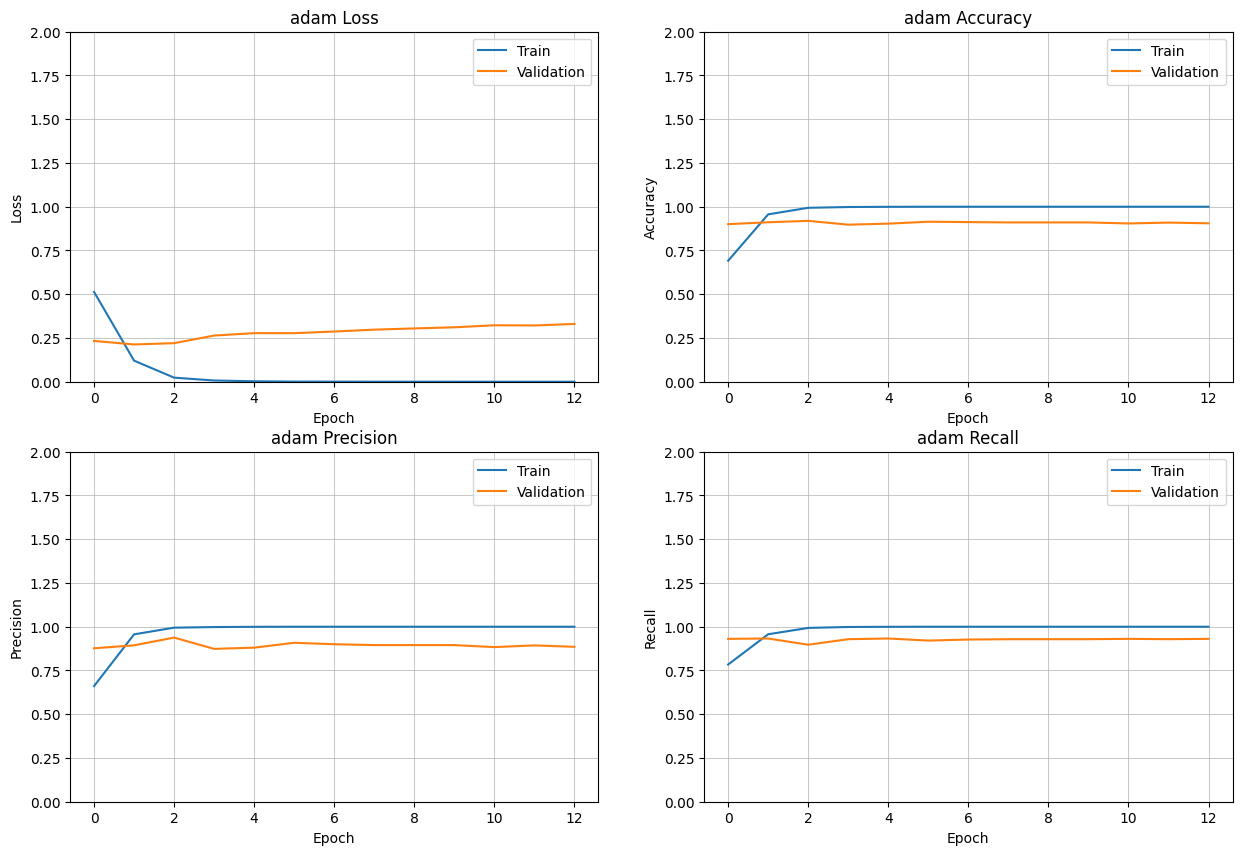

40/40 [==============================] - 0s 5ms/step - loss: 0.3446 - binary_accuracy: 0.8982 - precision: 0.9132 - recall: 0.8766


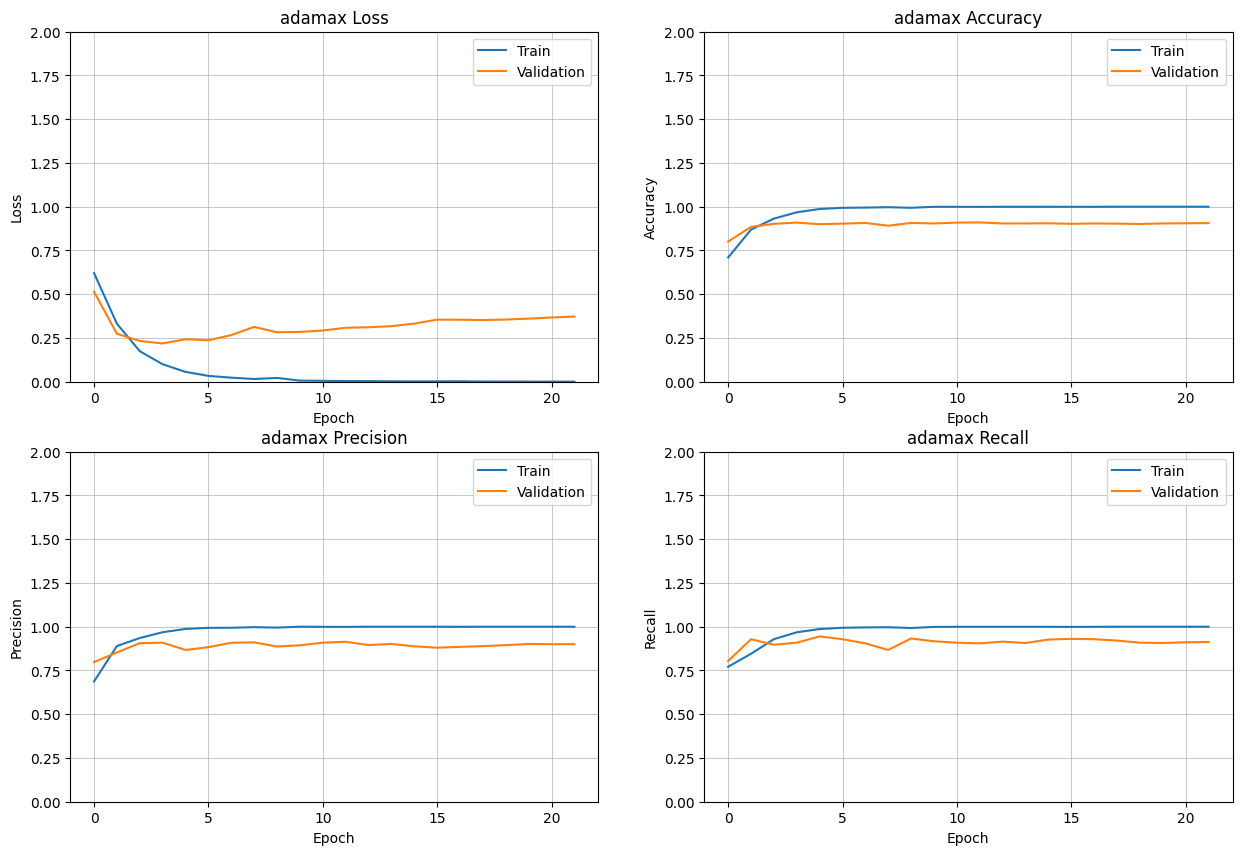

40/40 [==============================] - 0s 5ms/step - loss: 0.3153 - binary_accuracy: 0.8974 - precision: 0.9049 - recall: 0.8846


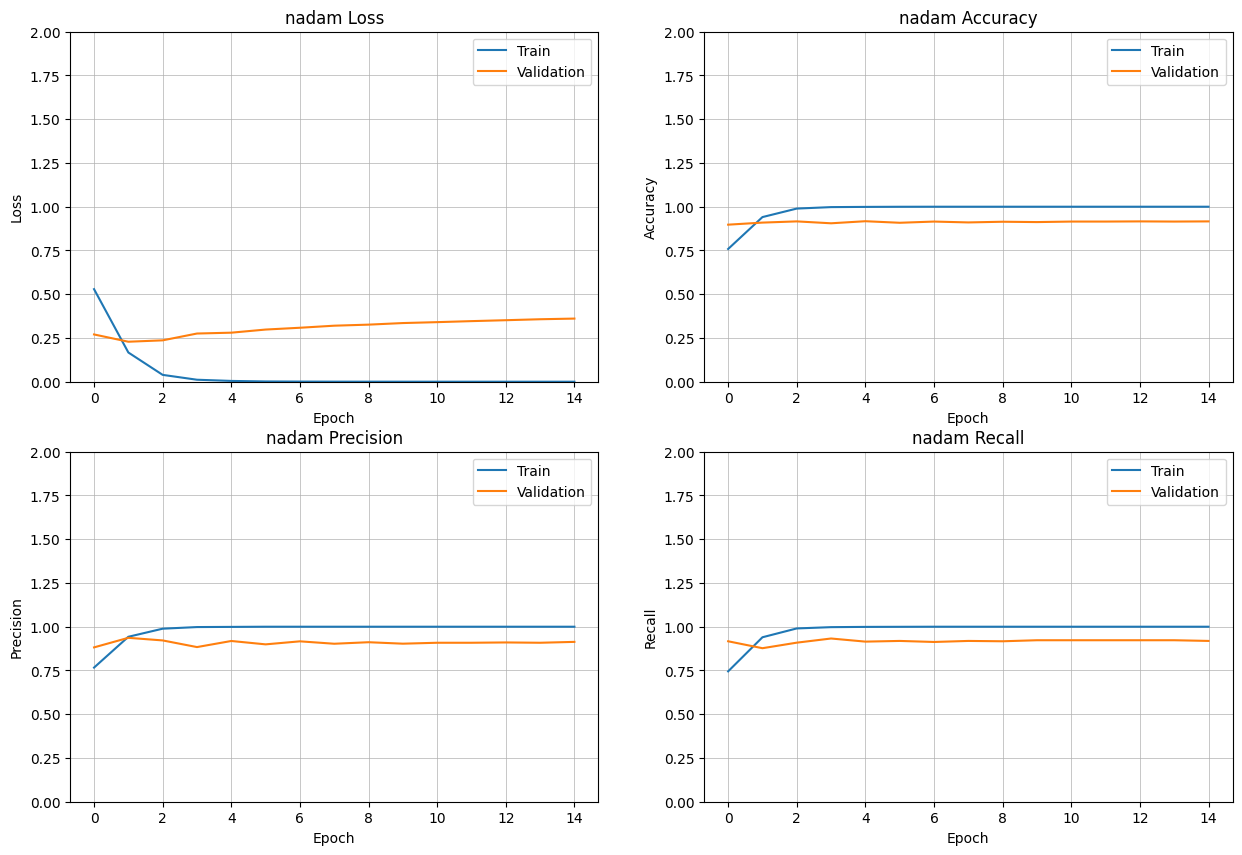

40/40 [==============================] - 0s 6ms/step - loss: 0.2276 - binary_accuracy: 0.9116 - precision: 0.9414 - recall: 0.8750


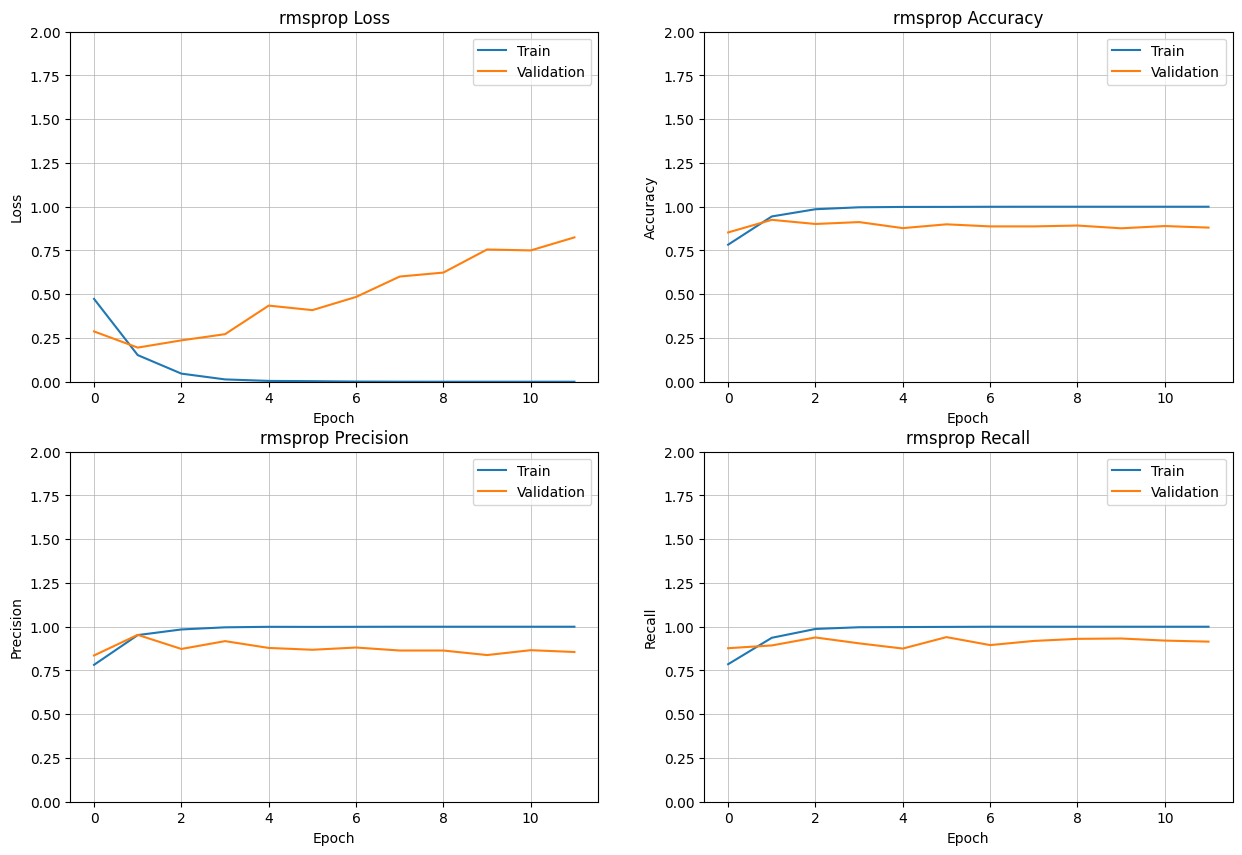

CPU times: user 8min 37s, sys: 35.4 s, total: 9min 12s
Wall time: 1min 49s


In [22]:
%%time
for optimizer in optimizers:
    model = compile_model(initialize_model(), optimizer)
    history = model.fit(X_train_token, y_train, 
          epochs=50, 
          batch_size=64,
          validation_split=0.2,
          callbacks=[es],
        verbose = 0, 
        use_multiprocessing=True
         )
    model.evaluate(X_test_token, y_test, verbose=1)
    plot_loss_accuracy(history, optimizer)

In [23]:
from tensorflow.keras.optimizers import Adam, RMSprop

In [30]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01]

40/40 [==============================] - 0s 5ms/step - loss: 0.6691 - binary_accuracy: 0.6172 - precision: 0.6164 - recall: 0.5897


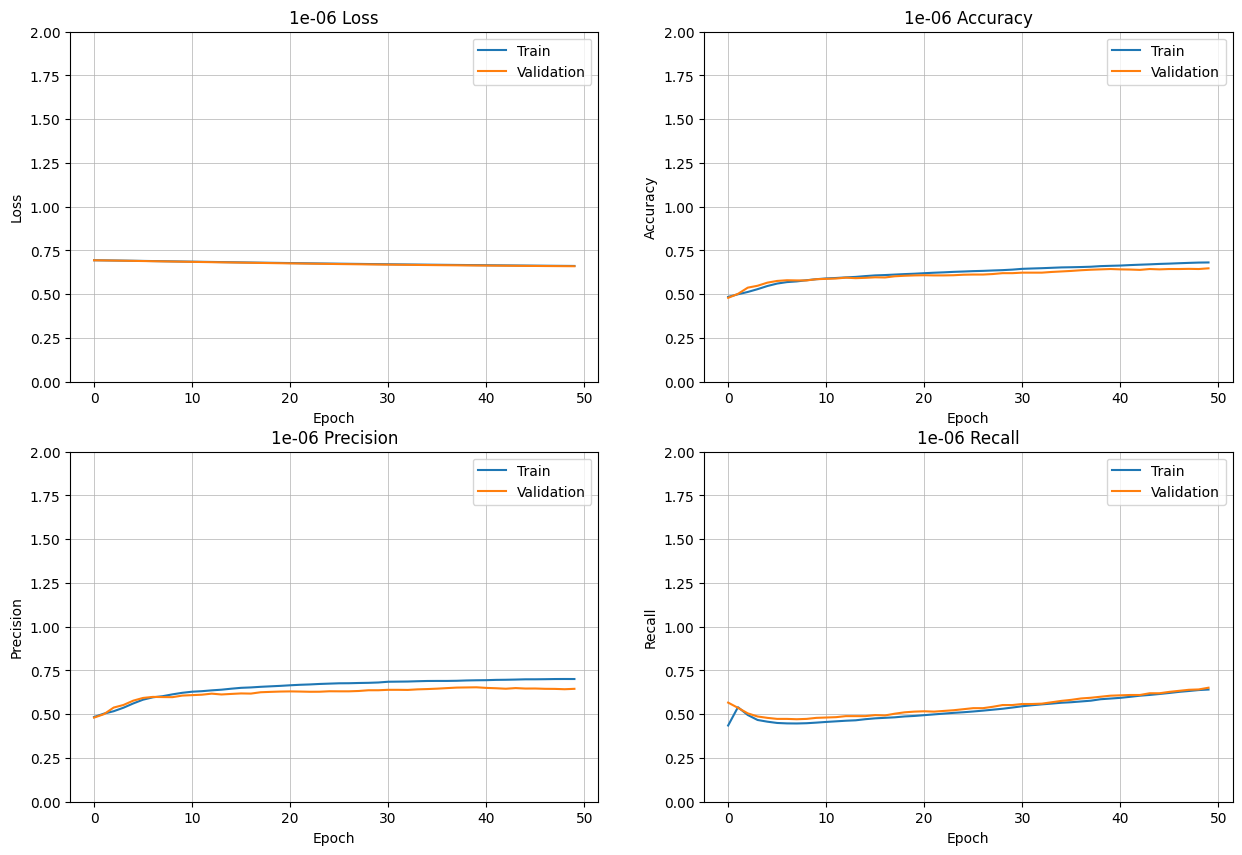

40/40 [==============================] - 0s 5ms/step - loss: 0.3048 - binary_accuracy: 0.8903 - precision: 0.8771 - recall: 0.9038


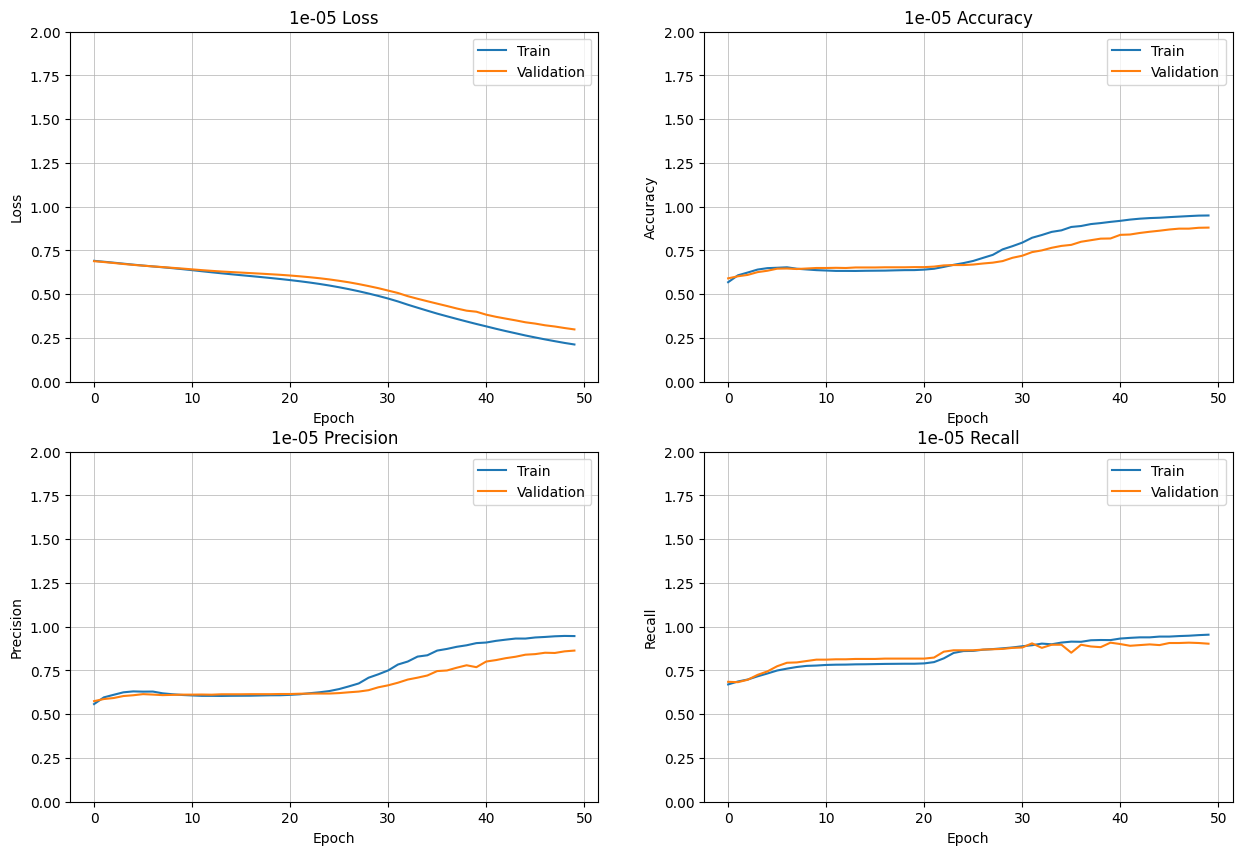

40/40 [==============================] - 0s 5ms/step - loss: 0.2305 - binary_accuracy: 0.9077 - precision: 0.9069 - recall: 0.9054


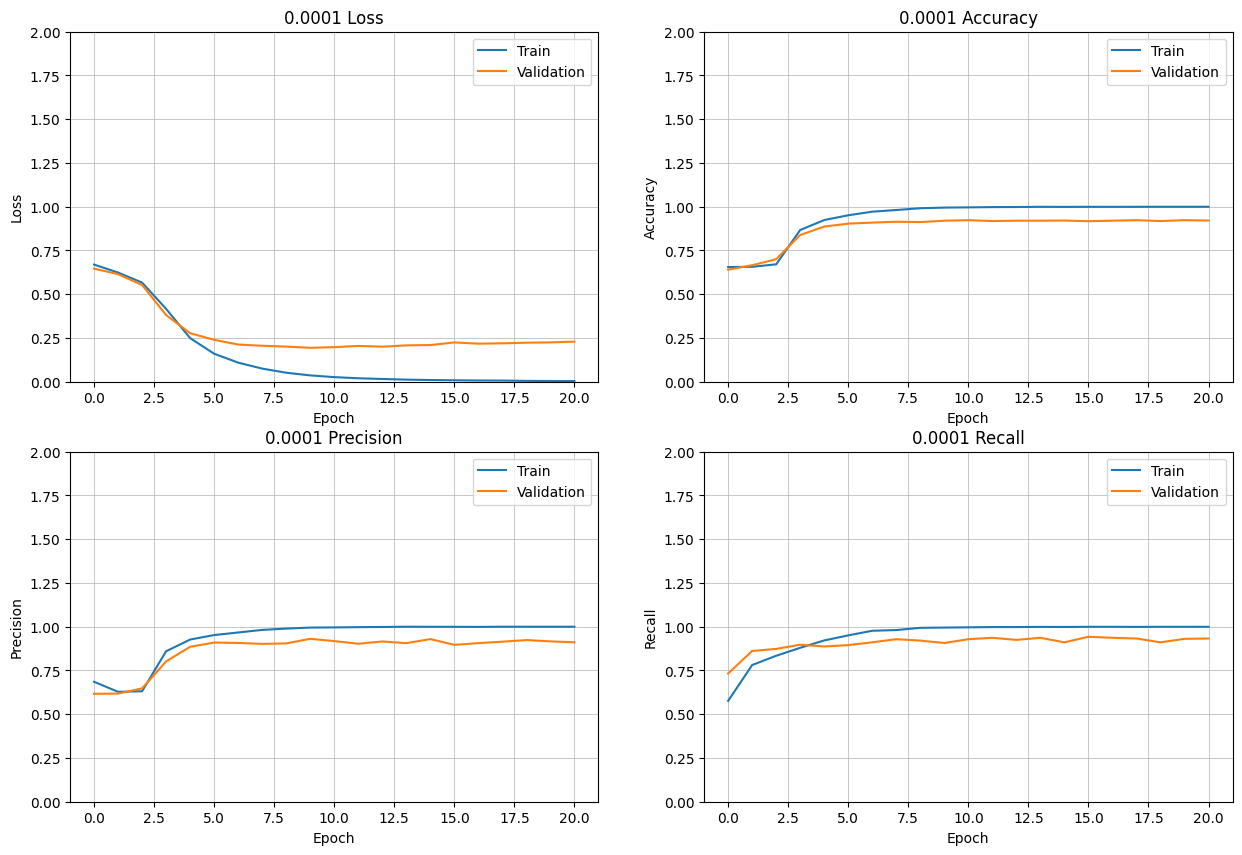

40/40 [==============================] - 0s 5ms/step - loss: 0.3878 - binary_accuracy: 0.9045 - precision: 0.9050 - recall: 0.9006


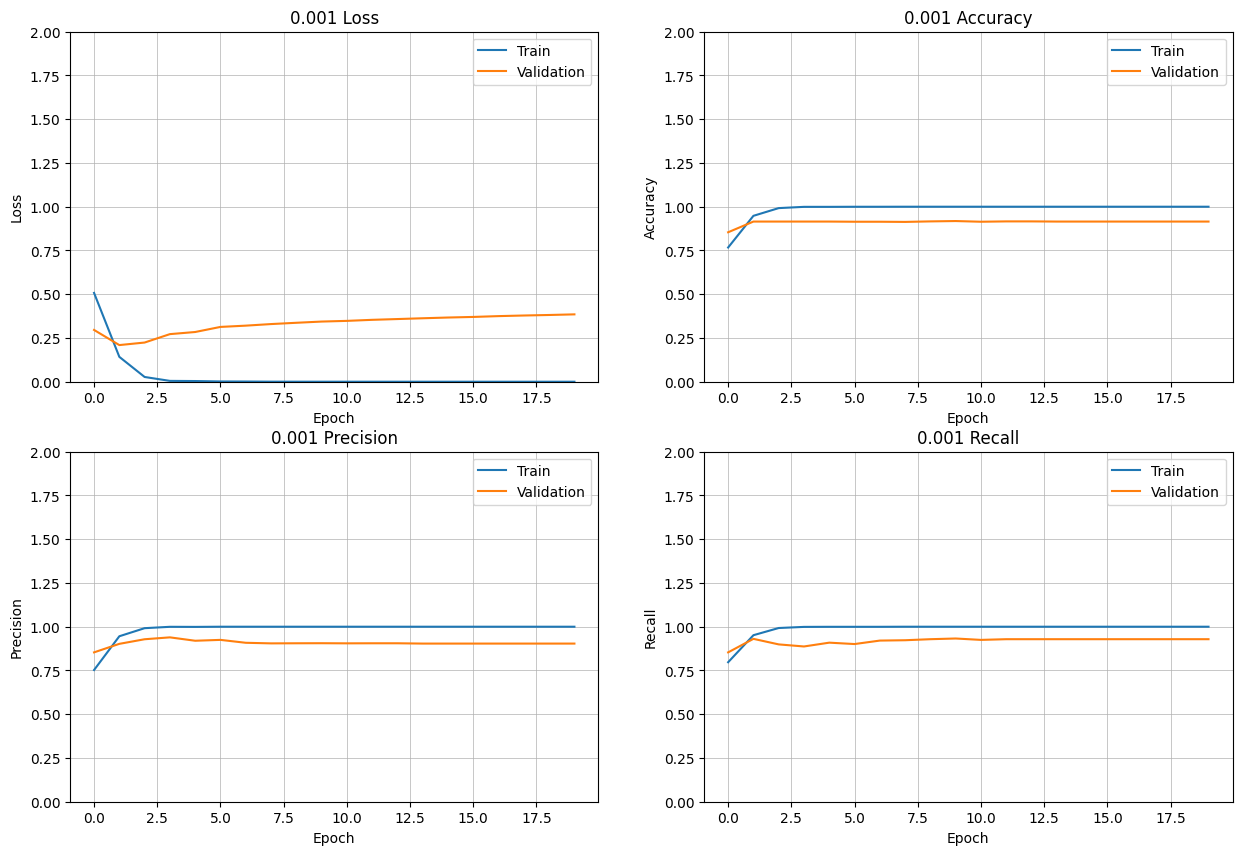

40/40 [==============================] - 0s 5ms/step - loss: 0.6356 - binary_accuracy: 0.8848 - precision: 0.8711 - recall: 0.8990


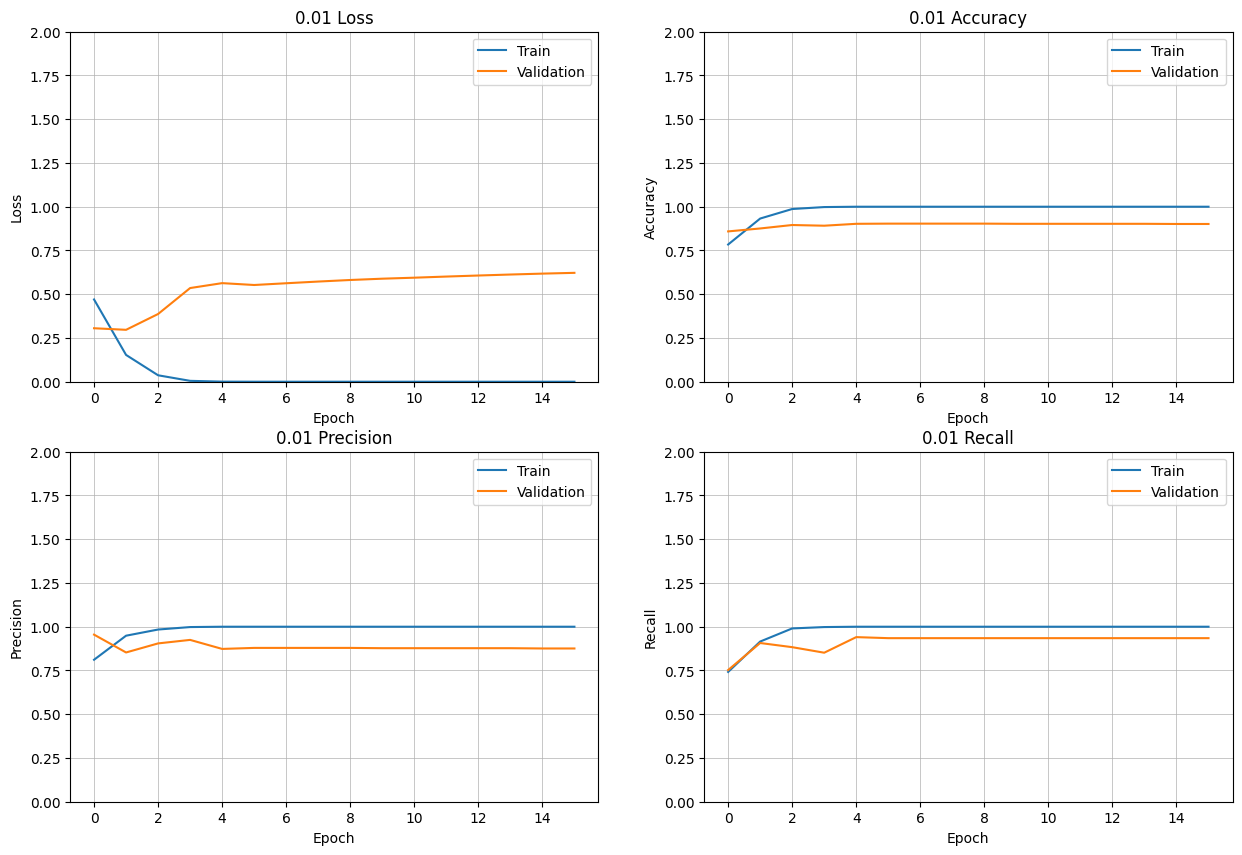

CPU times: user 36min 24s, sys: 1min 21s, total: 37min 46s
Wall time: 6min 31s


In [31]:
%%time
for learning_rate in learning_rates:
    adam = Adam(learning_rate=learning_rate)
    model = compile_model(initialize_model(), adam)
    history = model.fit(X_train_token, y_train, 
          epochs=50, 
          batch_size=64,
          validation_split=0.2,
          callbacks=[es],
        verbose = 0, 
        use_multiprocessing=True
         )
    model.evaluate(X_test_token, y_test, verbose=1)
    plot_loss_accuracy(history, learning_rate)

40/40 [==============================] - 0s 5ms/step - loss: 0.6738 - binary_accuracy: 0.5848 - precision: 0.6485 - recall: 0.3429


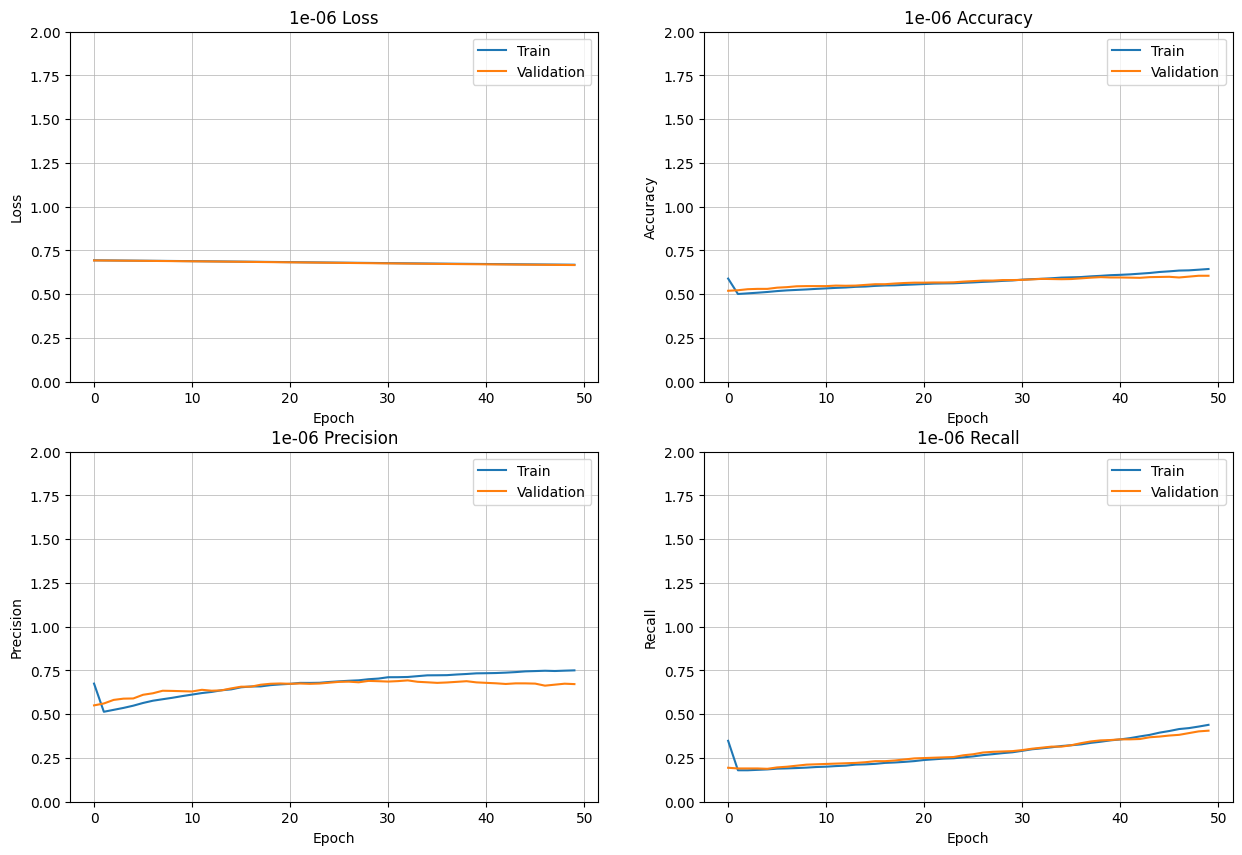

40/40 [==============================] - 0s 4ms/step - loss: 0.6479 - binary_accuracy: 0.6606 - precision: 0.6192 - recall: 0.8077


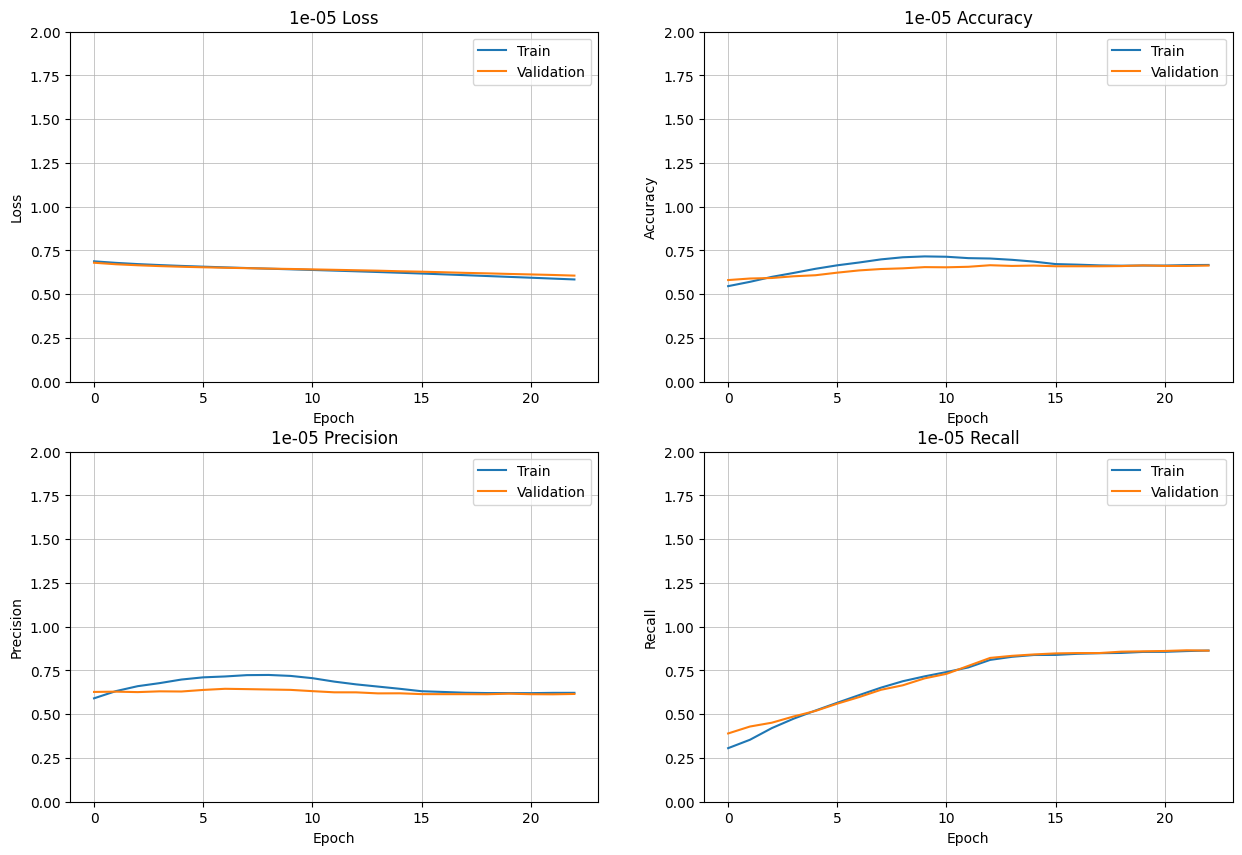

40/40 [==============================] - 0s 5ms/step - loss: 0.2785 - binary_accuracy: 0.9092 - precision: 0.9207 - recall: 0.8926


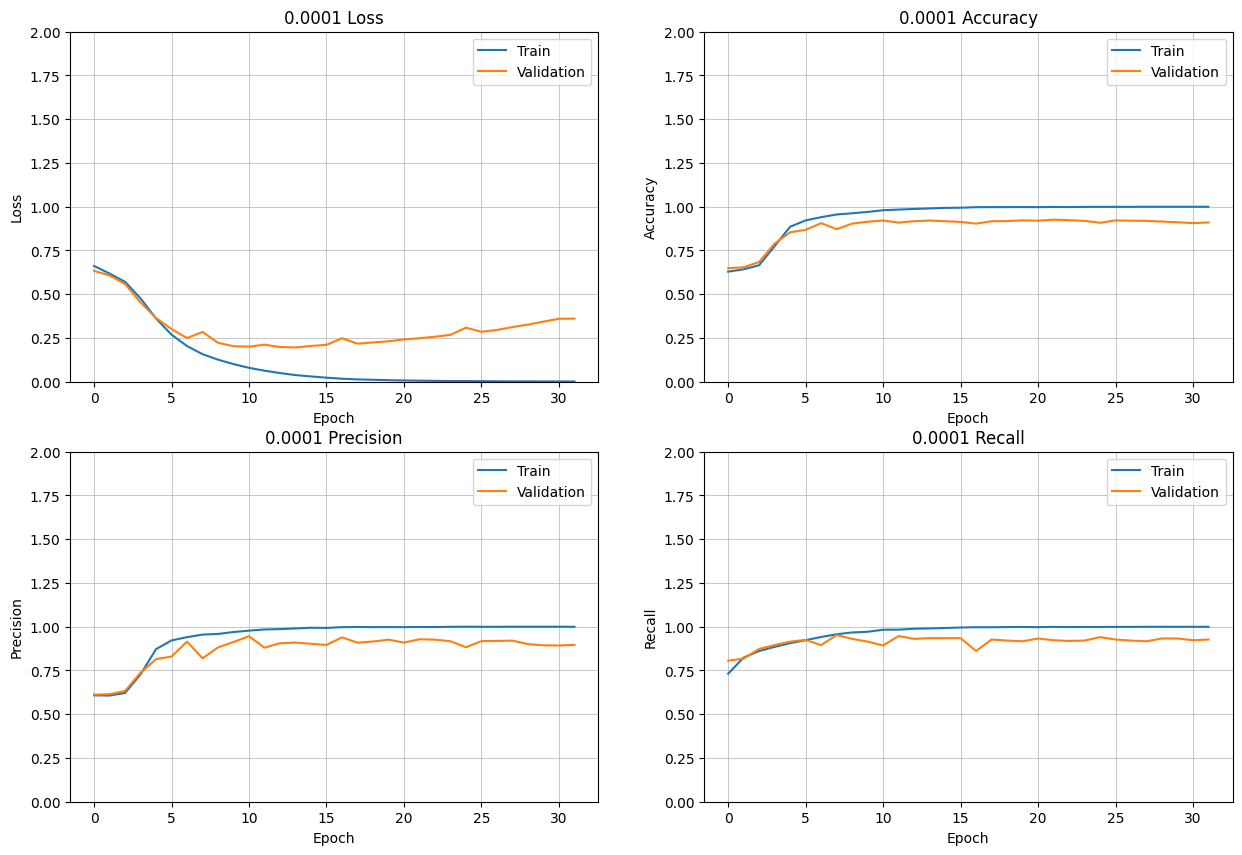

40/40 [==============================] - 0s 5ms/step - loss: 0.4306 - binary_accuracy: 0.8895 - precision: 0.9020 - recall: 0.8702


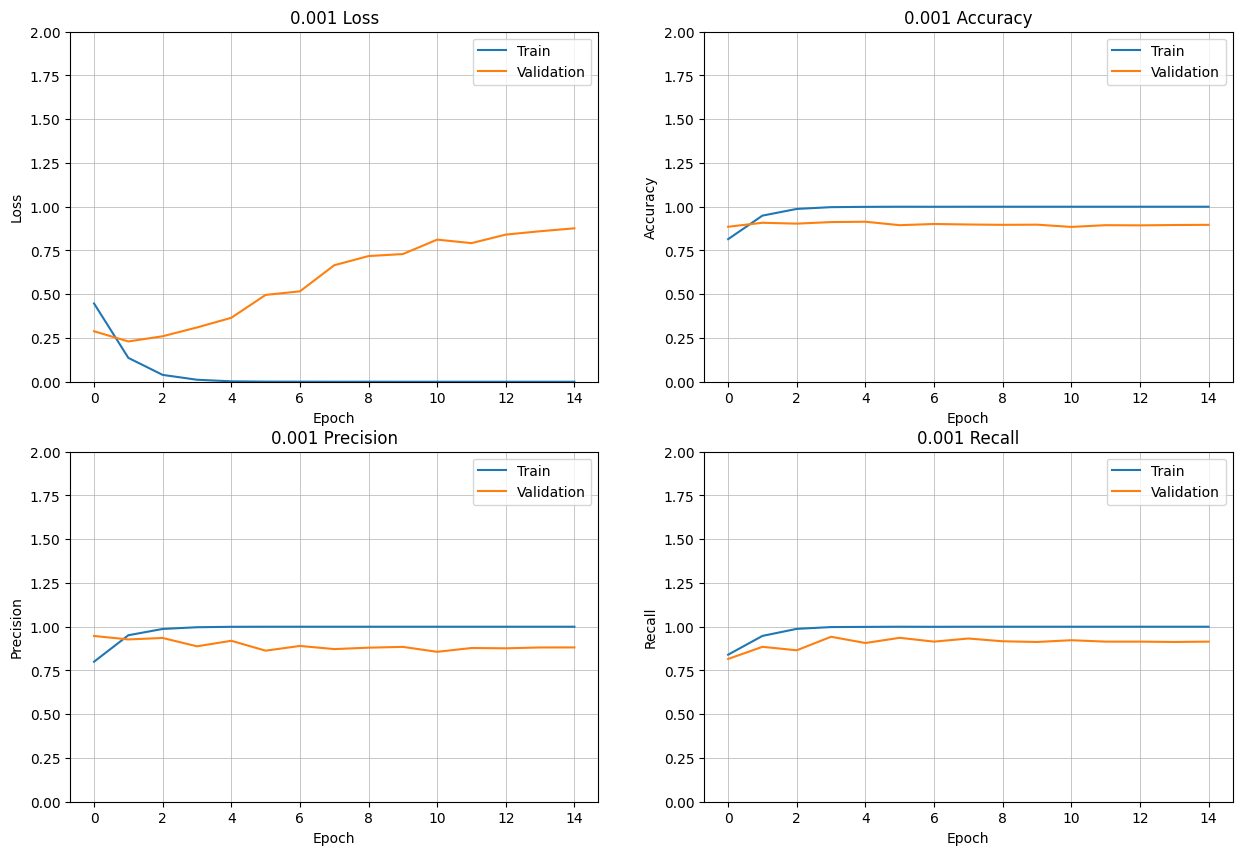

40/40 [==============================] - 0s 5ms/step - loss: 0.4439 - binary_accuracy: 0.8982 - precision: 0.9104 - recall: 0.8798


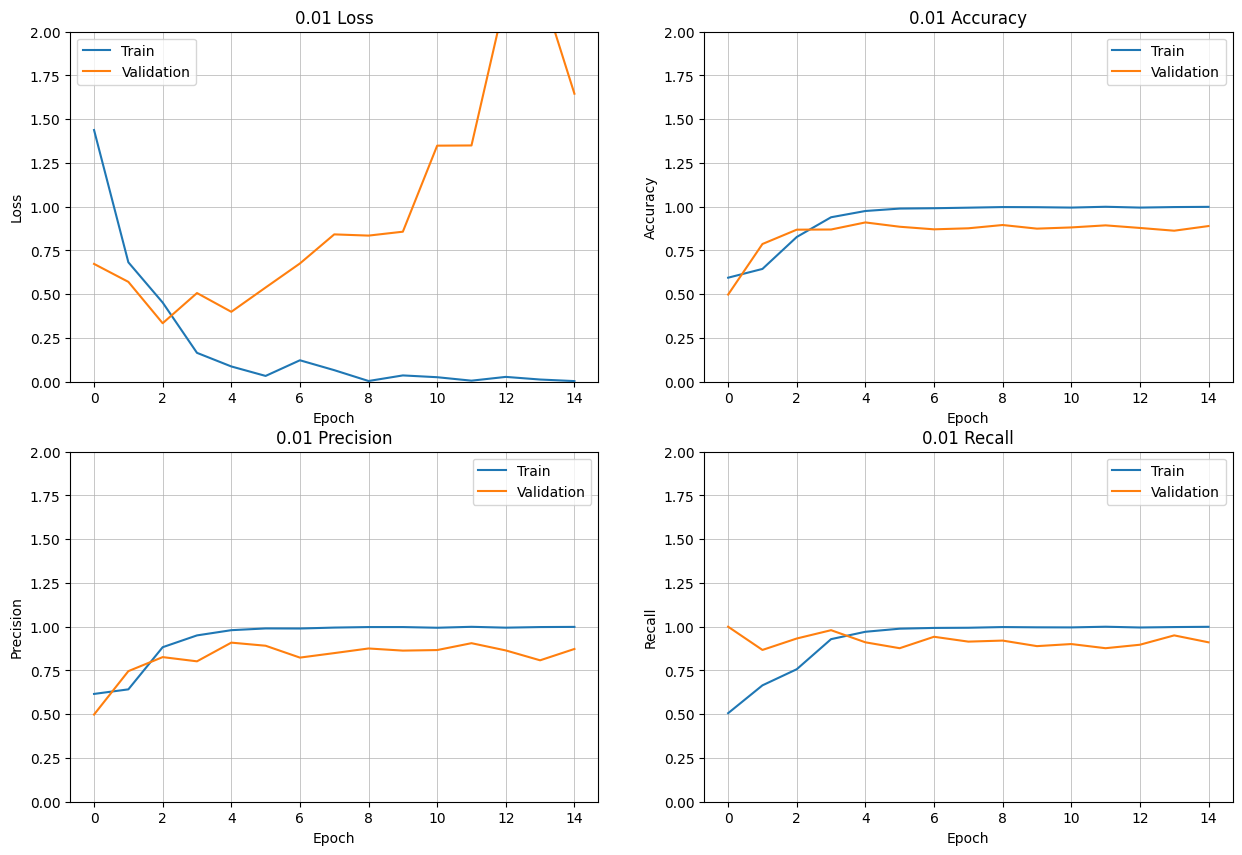

CPU times: user 14min 10s, sys: 57.9 s, total: 15min 8s
Wall time: 3min 11s


In [32]:
%%time
for learning_rate in learning_rates:
    rms = RMSprop(learning_rate=learning_rate)
    model = compile_model(initialize_model(), rms)
    history = model.fit(X_train_token, y_train, 
          epochs=50, 
          batch_size=64,
          validation_split=0.2,
          callbacks=[es],
        verbose = 0, 
        use_multiprocessing=True
         )
    model.evaluate(X_test_token, y_test, verbose=1)
    plot_loss_accuracy(history, learning_rate)

In [33]:
batches = [16, 32, 64]

40/40 [==============================] - 0s 5ms/step - loss: 0.2230 - binary_accuracy: 0.9100 - precision: 0.9061 - recall: 0.9119


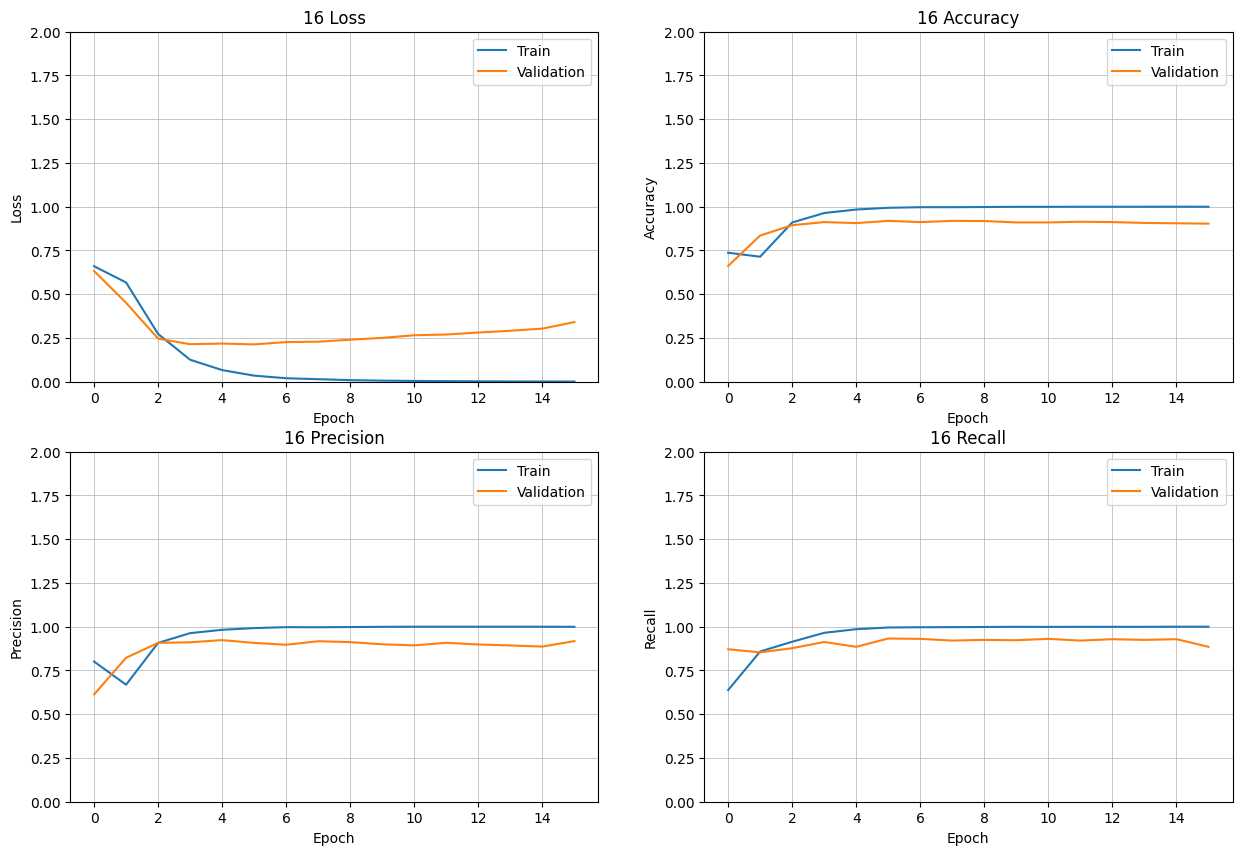

40/40 [==============================] - 0s 5ms/step - loss: 0.2450 - binary_accuracy: 0.9132 - precision: 0.9186 - recall: 0.9038


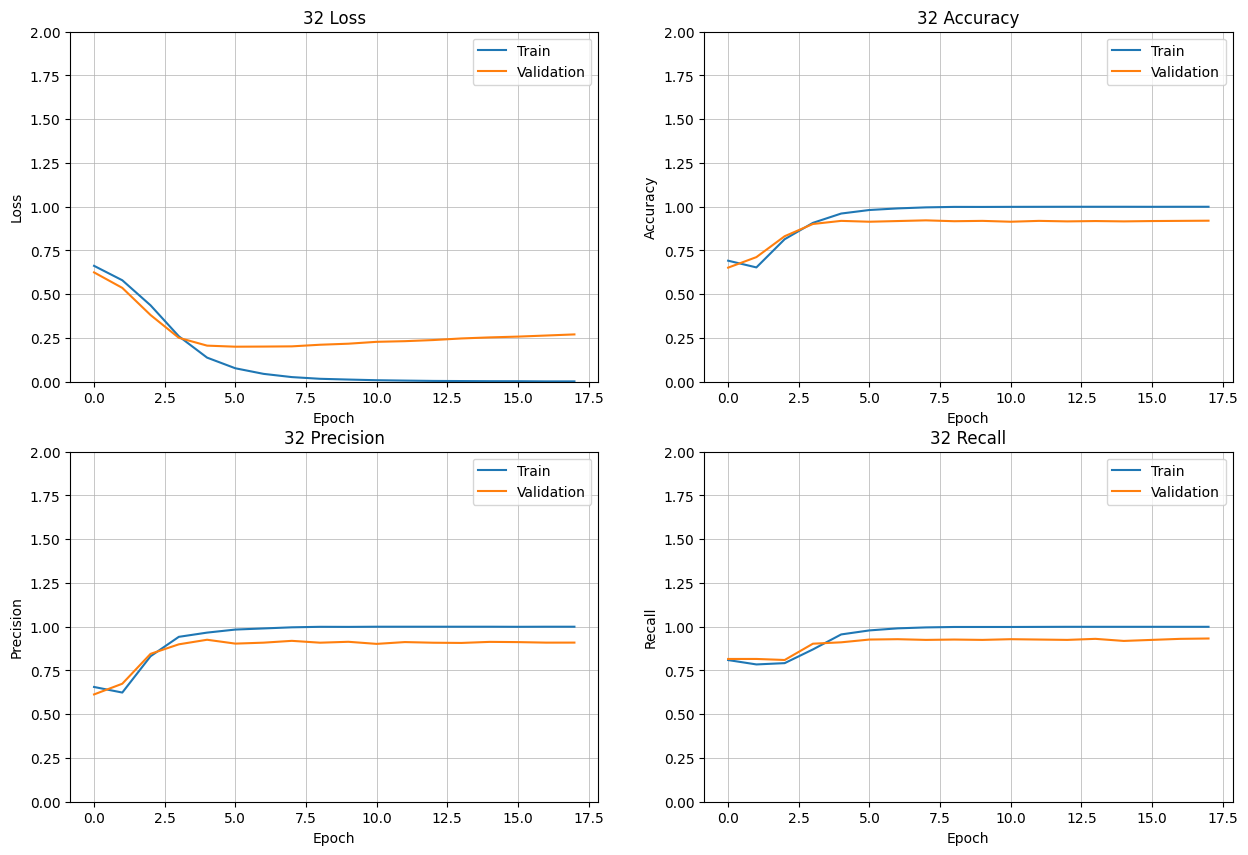

40/40 [==============================] - 0s 5ms/step - loss: 0.3058 - binary_accuracy: 0.9053 - precision: 0.9104 - recall: 0.8958


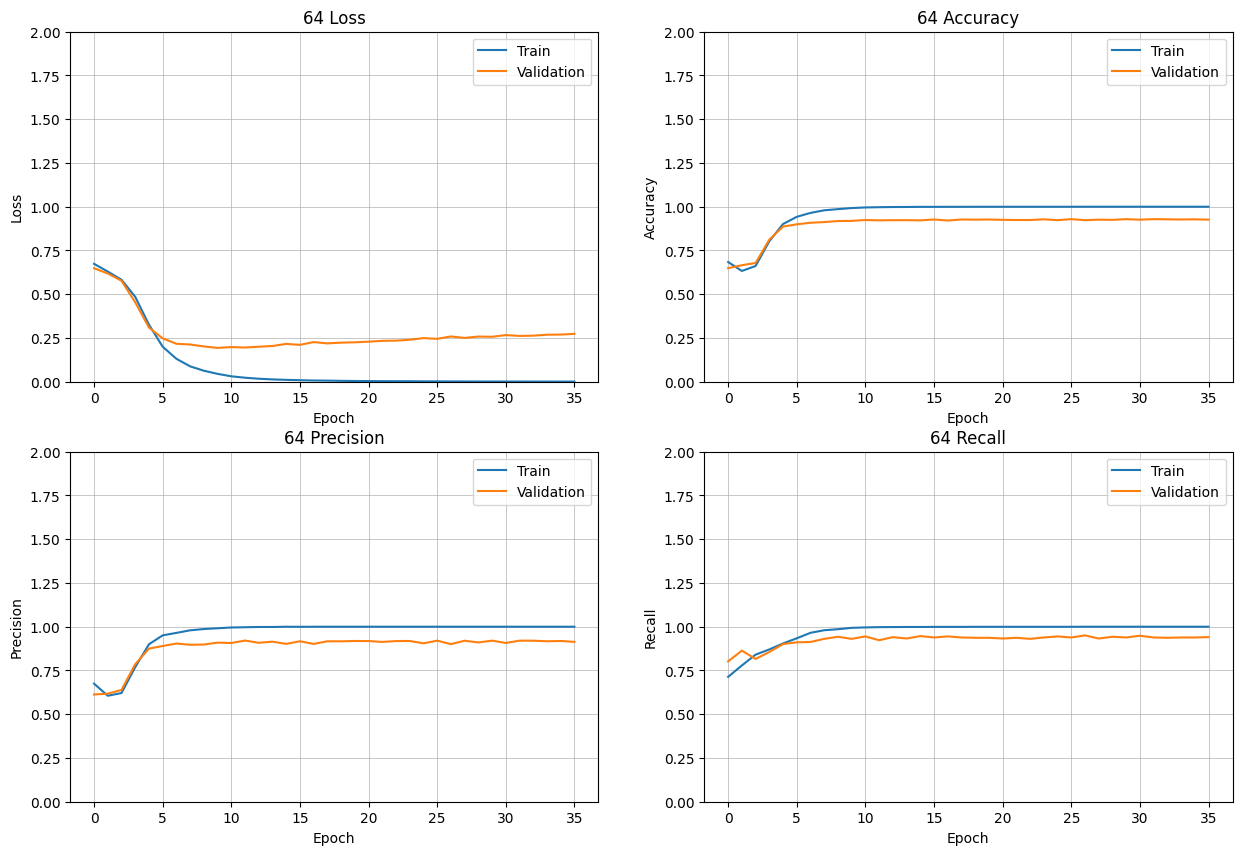

CPU times: user 27min 30s, sys: 1min 18s, total: 28min 49s
Wall time: 5min 3s


In [36]:
%%time
for batch in batches:
    model = compile_model(initialize_model(), Adam(learning_rate=0.0001))
    history = model.fit(X_train_token, y_train, 
          epochs=50, 
          batch_size=batch,
          validation_split=0.2,
          callbacks=[es],
        verbose = 0, 
        use_multiprocessing=True
         )
    model.evaluate(X_test_token, y_test, verbose=1)
    plot_loss_accuracy(history, batch)

40/40 [==============================] - 0s 5ms/step - loss: 0.2908 - binary_accuracy: 0.9069 - precision: 0.9121 - recall: 0.8974


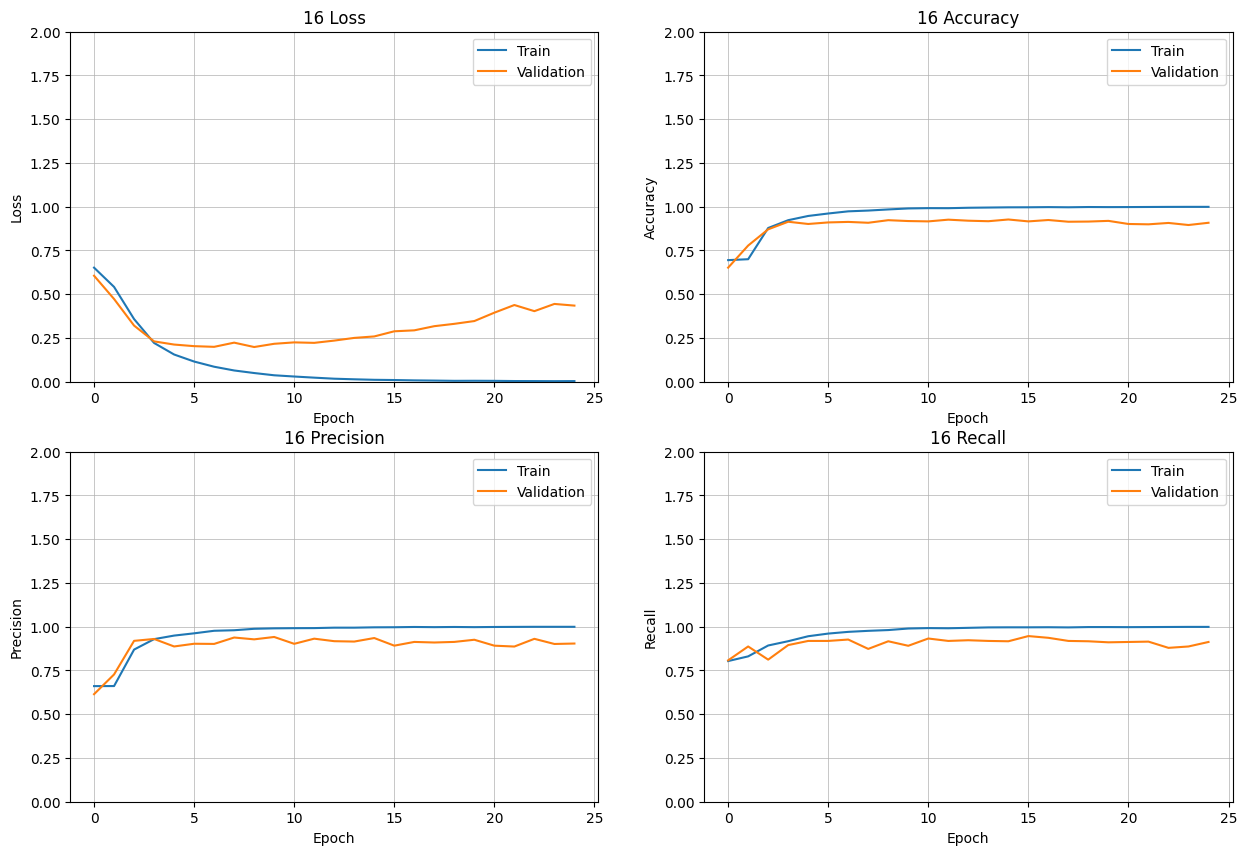

40/40 [==============================] - 0s 5ms/step - loss: 0.2467 - binary_accuracy: 0.9108 - precision: 0.9223 - recall: 0.8942


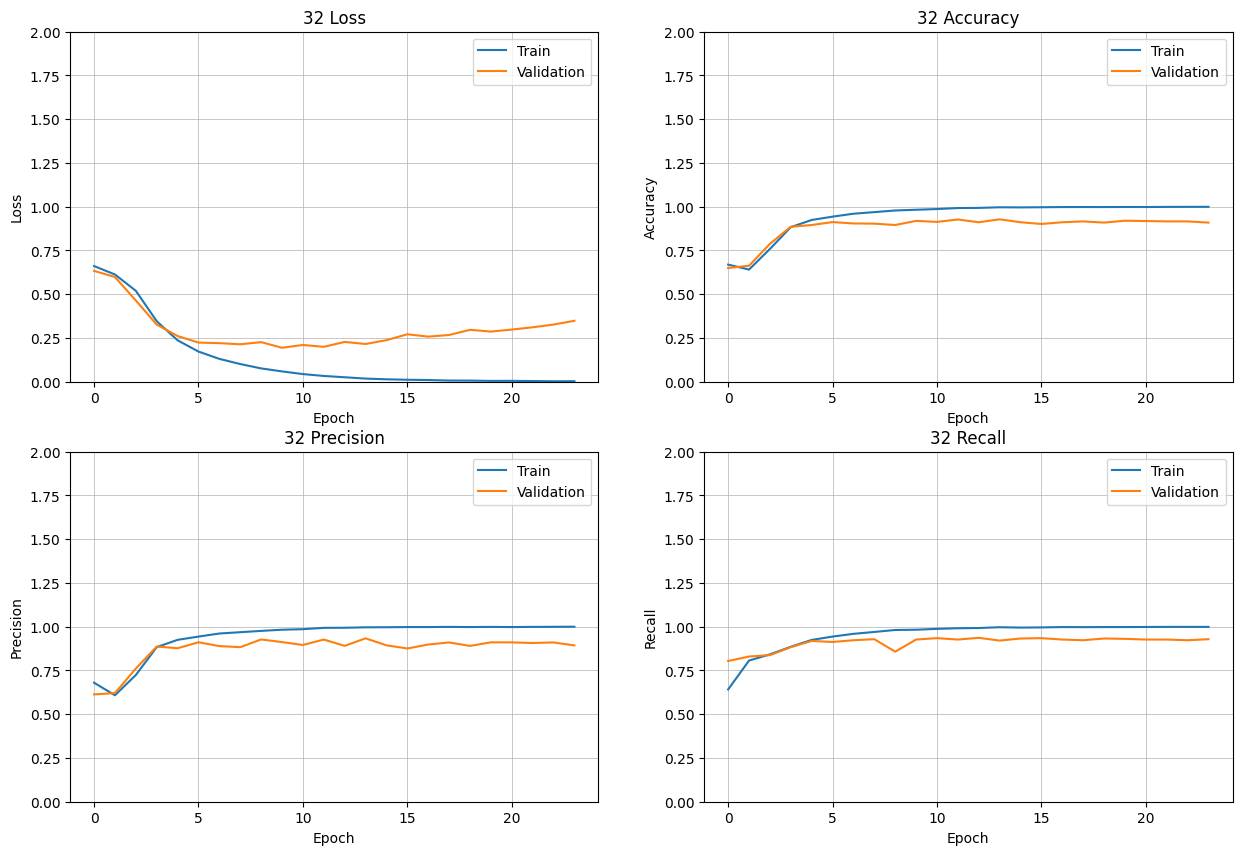

40/40 [==============================] - 0s 4ms/step - loss: 0.2973 - binary_accuracy: 0.9069 - precision: 0.9161 - recall: 0.8926


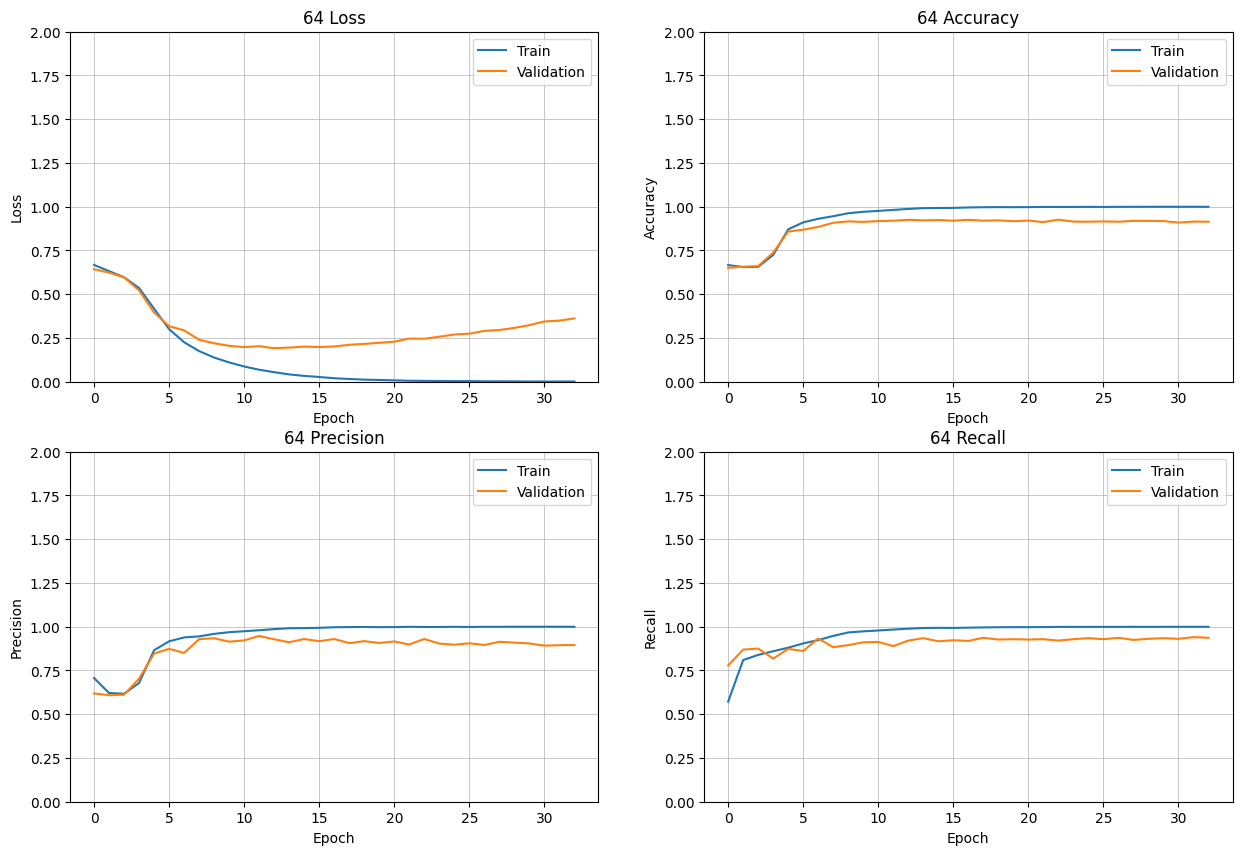

CPU times: user 12min 42s, sys: 1min 7s, total: 13min 49s
Wall time: 3min 3s


In [37]:
%%time
for batch in batches:
    model = compile_model(initialize_model(), RMSprop(learning_rate=0.0001))
    history = model.fit(X_train_token, y_train, 
          epochs=50, 
          batch_size=batch,
          validation_split=0.2,
          callbacks=[es],
        verbose = 0, 
        use_multiprocessing=True
         )
    model.evaluate(X_test_token, y_test, verbose=1)
    plot_loss_accuracy(history, batch)

# Conclusion:
## Best optimizer: RMSprop
## Best learning rate: 0.0001
## Best batch size: 32